In [108]:
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.geodesic
import matplotlib.pyplot as plt

Lab 1: Locating earthquakes
=====

In this exercise, we examine sets of digital seismograms recorded at different stations around the globe with the object of determining the epicenters and origin times of the earthquakes. (An epicenter is the projection point on the earth’s surface of the real location; a hypocenter is the real location of the earthquake source. The origin time of the earthquake is usually expressed as UTC.) Please read the instructions in full before beginning and note the helpful commands given in the Unix/Linux command and SAC intro sheets.

- Sheng Wang 		sheng.wang(at)anu.edu.au
- Hrvoje Tkalčić       	hrvoje.tkalcic(at)anu.edu.au

# Part 1

Use Seismic Analysis Tool (`SAC`) to read in 3 components of seismograms for each of the stations in the `EQ1` directory.  **Examine all 3 components** of recorded ground motion (velocity, but please note that the vertical axes of seismograms are expressed in counts).

For each station, **estimate the time at which the P and S waves arrive**. You will use `ppk` to pick and `wh` to store the time. The P wave will be the first prominent arrival on the vertical component; the S wave should be the first prominent arrival showing on both horizontals that typically has smaller (or negligible) amplitude on the vertical component.  Pick the P wave on the vertical (BHZ) component and the S wave on one of the horizontal components (BHN or BHE).  Calculate the difference in arrival times (“S-P time”).  **Complete columns 2-4 of the table below for the stations that are given to you**.  Be aware that other phases may arrive before the S (such as PP), which may lead to identification issues.  


| Station | P arrival time | S arrival time | S-P (seconds) | Distance (degrees) | Origin time |
|---------|:--------------:|:--------------:|:-------------:|:------------------:|:-----------:|
|   ENH   |                |                |               |                    |             |
|   XAN   |                |                |               |                    |             |
|   NWAO  |                |                |               |                    |             |
|   ...   |                |                |               |                    |             |

In [109]:
# Step 1.1
# Please run SAC in terminal and pick P, S wave for recordings at each station
# Then compute the time difference between P and S waves

# For example we measure the tdiff = 309.3s for ENH station, 482.1s for NIL station, 486.2s for YAK station
# We can form our dataset:
measurements = { 'ENH': {'stlo': 109.494, 'stla': 30.2762, 'tdiff': 309.3},
                 'NIL': {'stlo': 73.2686, 'stla': 33.6506, 'tdiff': 482.1},
                 'YAK': {'stlo': 129.680, 'stla': 62.0310, 'tdiff': 486.2},
               } 

In [110]:
# The function for inverting distance by providing a measured time difference
tmp = np.loadtxt('EQ1/timetable.txt')
ref_distance = tmp[:,0]
ref_tdiff = tmp[:,1]
def get_distance(tdiff, flag_plot=False):
    """
    Return the distance by providing a measured time difference
    """
    v = np.abs(ref_tdiff - tdiff)
    idx = np.argmin(v)
    dist = ref_distance[idx]
    if flag_plot:
        plt.plot(ref_distance, ref_tdiff, color='k', label='Theoretical time differences')
        plt.plot([0, 90], [tdiff, tdiff], color='b', label='Measured time difference')
        plt.plot([dist], [tdiff], 'o', color='r')
        plt.xlim([0, 90])
        plt.ylim([0, 700])
        plt.xlabel('Distance ($\degree$)')
        plt.ylabel('Time (s)')
        plt.legend()
    return dist

32.0

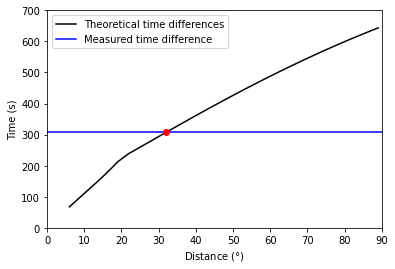

In [111]:
# Step 1.2
# We can invert the distance for the measurement at the station ENH, and plot for how to invert it
t = measurements['ENH']['tdiff']
get_distance(t, True)

In [152]:
# Step 1.3
# We can invert for all measurements without plotting
for stnm, v in measurements.items():
    v['dist'] = get_distance(v['tdiff'], False)
print(measurements)

{'ENH': {'stlo': 109.494, 'stla': 30.2762, 'tdiff': 309.3, 'dist': 32.0}, 'NIL': {'stlo': 73.2686, 'stla': 33.6506, 'tdiff': 482.1, 'dist': 59.0}, 'YAK': {'stlo': 129.68, 'stla': 62.031, 'tdiff': 486.2, 'dist': 60.0}}



**Construct a map** (directions follow) with a circle of constant radius (equal to the source-receiver distance) drawn around each station. All the circles should intersect at approximately one point. If any of the circles are inconsistent with the solution, go back and check your first steps for the appropriate station. 

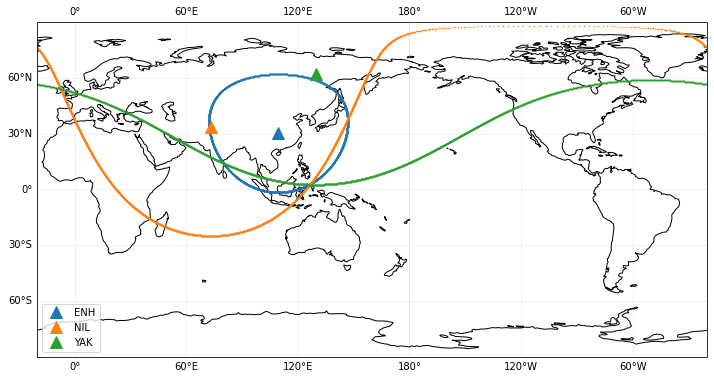

In [179]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=160.0))

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.coastlines()
app = cartopy.geodesic.Geodesic()
for stnm, v in measurements.items():
    stlo, stla, dist = v['stlo'], v['stla'], v['dist']
    line, = ax.plot(stlo, stla, '^', markersize=12, label=stnm, transform=ccrs.PlateCarree() )
    radius_in_meter = dist*110000 # convert degree to meter
    circle_points = app.circle(lon=stlo, lat=stla, radius=radius_in_meter, n_samples=3000, endpoint=True)
    ax.plot(circle_points[:,0], circle_points[:,1], '.', color=line.get_color(), markersize=1, transform=ccrs.PlateCarree())

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
ax.legend(loc='lower left')

# well, in the generate figure, the circles intersect. The intersection point is the inverted location for the earthquake.
# 

If the solution looks good, plot a closer view of the region around the epicentre and estimate as accurately as possible the coordinates of the earthquake. One way to do this is to find the point on the map that minimizes the sum of the distances (L1 norm) or distances squared (L2 norm) between the selected point and each of the circles. Write the estimated longitude and latitude on the lines of the attached table.

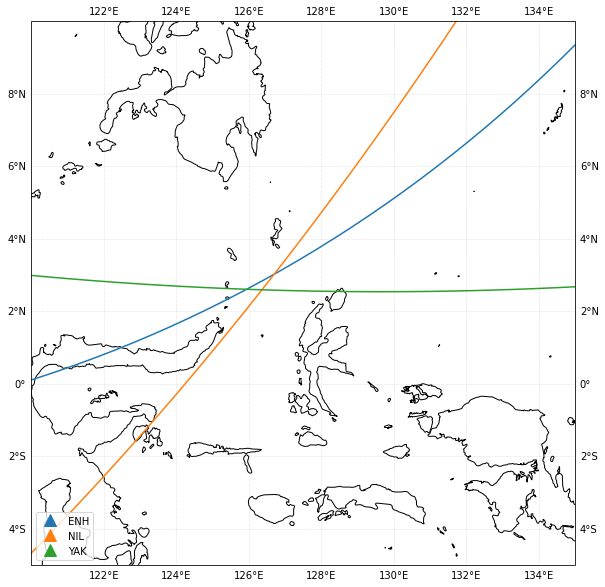

In [182]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=160.0))

ax.coastlines()
app = cartopy.geodesic.Geodesic()
for stnm, v in measurements.items():
    stlo, stla, dist = v['stlo'], v['stla'], v['dist']
    line, = ax.plot(stlo, stla, '^', markersize=12, label=stnm, transform=ccrs.PlateCarree() )
    radius_in_meter = dist*110000 # convert degree to meter
    circle_points = app.circle(lon=stlo, lat=stla, radius=radius_in_meter, n_samples=1000, endpoint=True)
    ax.plot(circle_points[:,0], circle_points[:,1], '-', color=line.get_color(), markersize=3, transform=ccrs.PlateCarree())

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
ax.legend(loc='lower left')
ax.set_extent([120, 135, -5, 10], crs=ccrs.PlateCarree())

# The generated Figure presents a closer view. It shows the imperfection of the result. 
# The circles do not intersect at a single point!
#
# Think about a way find the point on the map that minimizes the sum of the distances (L1 norm) or 
# distances squared (L2 norm) between the selected point and each of the circles.
# Write the estimated longitude and latitude on the lines of the attached table.

Please submit the following:

- [ ] the table you completed during the exercise,
- [ ] the maps.
- [ ] a short summary detailing your thought process regarding picking any difficult phases and how the epicentral location could be improved by this method.